In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

## Import datasets

In [3]:
VABB = pd.read_csv("data/cleaning/VABB_books_isbn_level.csv", dtype={"isbn":"str"})
languages = VABB[["isbn", "VABB_lg"]]

In [4]:
def language_column(df):
    df.VABB_lg = df.VABB_lg.str.split(";").copy()
    for i in range(len(df)):
        if len(df.VABB_lg.iloc[i])> 1:
            df.VABB_lg.iloc[i] = "mul"
        else:
            df.VABB_lg.iloc[i] = ";".join(df.VABB_lg.iloc[i])
    return df

In [5]:
df_languages = language_column(languages)

<ipython-input-4-550ee16e6427>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.VABB_lg = df.VABB_lg.str.split(";").copy()
<ipython-input-4-550ee16e6427>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.VABB_lg.iloc[i] = "mul"
<ipython-input-4-550ee16e6427>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.VABB_lg.iloc[i] = ";".join(df.VABB_lg.iloc[i])


In [6]:
con_uc = sqlite3.connect("unicat_holdings.db")

In [7]:
holding_uc = pd.read_sql("""SELECT i.isbn, h.work_id, COUNT(distinct location) library_count
                        FROM holding h
                        JOIN isbn_search i ON h.work_id = i.work_id
                        GROUP BY i.isbn""", con_uc)

In [8]:
con_cc = sqlite3.connect("cultuurconnect.db")

In [10]:
holding_cc = pd.read_sql("""SELECT i.isbn, h.frabl, COUNT(distinct library) library_count
            FROM holding h
            JOIN isbns i ON h.frabl = i.frabl
            GROUP BY i.isbn""", con_cc)

In [17]:
# merge UniCat with languages
df = df_languages.merge(holding_uc, on="isbn", how="outer").rename(columns={"library_count":"uc_library_count"})

In [18]:
df = df.merge(holding_cc, on="isbn", how="outer").rename(columns={"library_count":"cc_library_count"})

In [19]:
df.head(2)

,isbn,VABB_lg,work_id,uc_library_count,frabl,cc_library_count
0,9780000000002,mul,NaN,NaN,NaN,NaN
1,9780000001948,mul,NaN,NaN,NaN,NaN


In [20]:
df = df.fillna(0).copy()

In [22]:
df["inCC"] = df.cc_library_count.apply(lambda x: True if x>0 else False)

In [23]:
df["inUC"] = df.uc_library_count.apply(lambda x: True if x>0 else False)

## Visualize

In [24]:
VABB_top_5 = pd.DataFrame(df.groupby("VABB_lg").isbn.count()).reset_index().sort_values(by = "isbn", ascending=False).head(5)
VABB_total = len(df)
VABB_top_5["percentage_VABB"] = VABB_top_5.isbn.apply(lambda x: (x/VABB_total)*100)
VABB_top_5

,VABB_lg,isbn,percentage_VABB
8,eng,24187,51.857808
7,dut,12959,27.784567
11,fre,3552,7.615617
21,mul,3032,6.500718
12,ger,1446,3.100277


In [25]:
cultuurconnect = df[df.inCC == True].copy()
cultuurconnect_top_5 = cultuurconnect.groupby("VABB_lg").isbn.count().reset_index().sort_values(by="isbn", ascending=False).head(5)
cultuurconnect_total = len(cultuurconnect)
cultuurconnect_top_5["percentage_CC"] = cultuurconnect_top_5.isbn.apply(lambda x: (x/cultuurconnect_total)*100)

In [26]:
unicat = df[df.inUC == True].copy()
unicat_top_5 = unicat.groupby("VABB_lg").isbn.count().reset_index().sort_values(by="isbn",ascending=False).head(5)
unicat_total = len(unicat)
unicat_top_5["percentage_UC"] = unicat_top_5.isbn.apply(lambda x: (x/unicat_total)*100)

In [27]:
top_5 = VABB_top_5.merge(cultuurconnect_top_5, how="left", on="VABB_lg")
top_5 = top_5.merge(unicat_top_5, how="left", on="VABB_lg")

In [28]:
# color scheme for the plots = Uantwerpen huisstijl
colors = ("#ea2c38","#002e65")
ua_red = "#ea2c38"
ua_blue = "#002e65"
fsw_green = "#ada500"
cfont = {'fontname':'Calibri'}

In [29]:
top_5

,VABB_lg,isbn_x,percentage_VABB,isbn_y,percentage_CC,isbn,percentage_UC
0,eng,24187,51.857808,910,11.254019,11736,45.980254
1,dut,12959,27.784567,5990,74.078654,8371,32.796584
2,fre,3552,7.615617,208,2.572347,2308,9.042470
3,mul,3032,6.500718,904,11.179817,1950,7.639868
4,ger,1446,3.100277,45,0.556517,726,2.844382


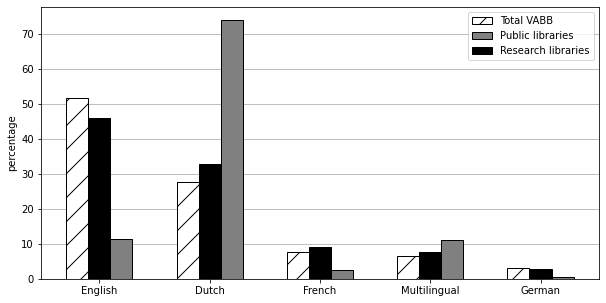

In [44]:
plt.rc('axes', axisbelow=True) #to show grid behind the figure
fig, ax = plt.subplots(figsize = (10,5))



x = top_5.VABB_lg
y_VABB = top_5.percentage_VABB
y_CC = top_5.percentage_CC
y_UC = top_5.percentage_UC

X_axis = np.arange(len(x))

plt.bar(X_axis - 0.2, y_VABB, 0.2, label = 'Total VABB', color = "white", edgecolor = "black", hatch = "/")
plt.bar(X_axis + 0.2, y_CC, 0.2, label = 'Public libraries', color = "grey", edgecolor = "black")
plt.bar(X_axis - 0.0, y_UC, 0.2, label = "Research libraries", color = "black", edgecolor = "black")

ax.grid(axis='y',zorder=-1.0)

ax.set_ylabel("percentage")
plt.xticks(X_axis, ["English","Dutch","French","Multilingual","German"])
plt.legend()


plt.savefig("plots/language distribution paper_colorblind.png")